# Test Download Copernicus Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
from tqdm import tqdm
from mangroves.collection import Collection
from mangroves.geometry import Region
from mangroves.utils import haversine
from mangroves.constants import RGB_BANDS

N_BANDS = len(RGB_BANDS)

with open('/home/nus/workspace/tutorial/GEE/gee_project_key.txt', "r") as f:
    project = f.readline().strip()

collection = Collection(project=project)

2025-11-27 15:31:40,377 - INFO - Google Earth Engine initialized successfully with service account


### Inputs

In [2]:
nPixels = 256
# lat0_deg, lon0_deg = 1.41150, 103.9569  # Pulau Ubin 
lat0_deg, lon0_deg = 1.375310, 103.985827  # Changi Airport
year = 2020

### Reference Point

In [3]:
pt0 = ee.Geometry.Point([lon0_deg, lat0_deg], proj='EPSG:4326')
img = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterDate(f'{year}-01-01', f'{year+1}-01-01')
               .filterBounds(pt0)
               .first())

### Download Image

Pixel corner distances: [np.float64(1810.1933598375465), np.float64(1810.1933598397611), np.float64(1810.1933598375465), np.float64(1810.193359837527)]


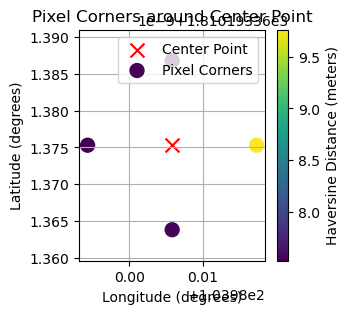

In [4]:
region = Region(lat_deg=lat0_deg, lon_deg=lon0_deg, nPixels=nPixels)

pts_distance = [
    np.sqrt(2. * haversine(lat0_deg, lat_deg, lon0_deg, lon_deg)**2) for lat_deg, lon_deg in region.pts
]

print("Pixel corner distances:", pts_distance)

plt.figure(figsize=(3, 3))
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.scatter(
    [lon for _, lon in region.pts],
    [lat for lat, _ in region.pts],
    marker='o',
    s=100,
    label='Pixel Corners',
    c=pts_distance,
    cmap='viridis',
)
plt.colorbar(label='Haversine Distance (meters)')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Pixel Corners around Center Point')
plt.axis('equal')
plt.legend()
plt.grid()

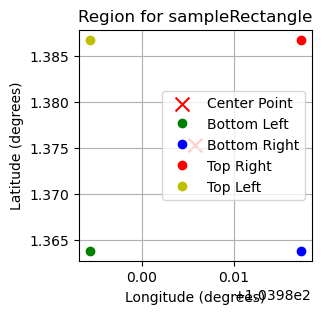

In [5]:
pixel_data = img.select(RGB_BANDS).sampleRectangle(region=region.region, properties=[], defaultValue=0)
properties = pixel_data.getInfo()['properties']

xMin, xMax, yMin, yMax = (
    region.coords['xMin'], region.coords['xMax'],
    region.coords['yMin'], region.coords['yMax']
)
plt.figure(figsize=(3, 3))
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.plot(xMin, yMin, 'go', label='Bottom Left')
plt.plot(xMax, yMin, 'bo', label='Bottom Right')
plt.plot(xMax, yMax, 'ro', label='Top Right')
plt.plot(xMin, yMax, 'yo', label='Top Left')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Region for sampleRectangle')
plt.axis('equal')
plt.legend()
plt.grid()

In [6]:
region_coordinates = region.region.getInfo()['coordinates'][0]

distance_corners = [
    haversine(lat0_deg, lat, lon0_deg, lon) for lon, lat in region_coordinates
]

distance_corners

[np.float64(1810.1955366136174),
 np.float64(1810.1955366147347),
 np.float64(1810.1911708660773),
 np.float64(1810.1911708649604),
 np.float64(1810.1955366136174)]

In [8]:
bands_data = {}
for i in range(N_BANDS):
    band_name = RGB_BANDS[i]
    if band_name in properties:
        band_array = np.array(properties[band_name])
        band_array = np.flipud(band_array)  # Apply flipud for correct display
        bands_data[band_name] = band_array

image_stack = []
for band_name in RGB_BANDS:
    if band_name in bands_data:
        image_stack.append(bands_data[band_name])
    else:
        # Fill missing bands with zeros
        if bands_data:
            image_shape = list(bands_data.values())[0].shape
            image_stack.append(np.zeros(image_shape))

# Stack to create D*H*W array
patch = np.stack(image_stack, axis=0)
patch.shape

(3, 256, 257)

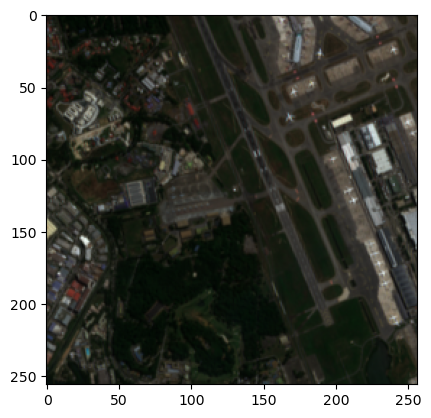

In [9]:
patch_3channels = np.transpose(patch, (1, 2, 0))[:, :, :3]
patch_3channels = (patch_3channels - patch_3channels.min()) / (patch_3channels.max() - patch_3channels.min())  # Normalize for display
plt.imshow(patch_3channels)

In [10]:
data = {}

for i, band_name in enumerate(RGB_BANDS):
    data[band_name] = patch[i, :nPixels, :nPixels].flatten()

data = pd.DataFrame(data)
data.head()

,B4,B3,B2
0,1166,1136,993
1,759,841,585
2,980,994,792
3,1106,1078,919
4,771,897,687


In [11]:
output_file = '/home/nus/Downloads/eo_changi_airport_2020.csv'

data.to_csv(output_file, index=False)